In [57]:
# **EEG PROCESSING**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import mne
#C:\\Users\\Usuario\\Downloads\\s01_ex01_s01 (1).txt
#Tres minutos de estado de reposo, con los ojos abiertos durante tres sesiones.(una sesion en este caso)


   Unnamed: 0          T7           F8          Cz          P4
0        9000  533.956726 -1017.742737  434.163116  345.218933
1        9001  516.659729 -1034.703125  421.286652  339.302429
2        9002  521.615051 -1031.969238  432.577393  335.192261
3        9003  548.441345 -1010.782776  452.522278  344.815033
4        9004  537.386230 -1029.429932  443.662476  348.222076


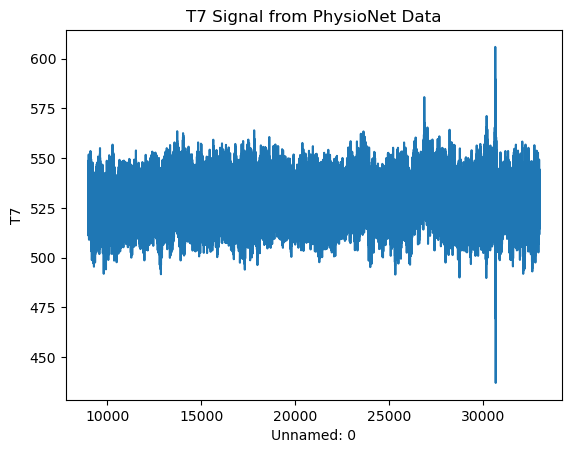

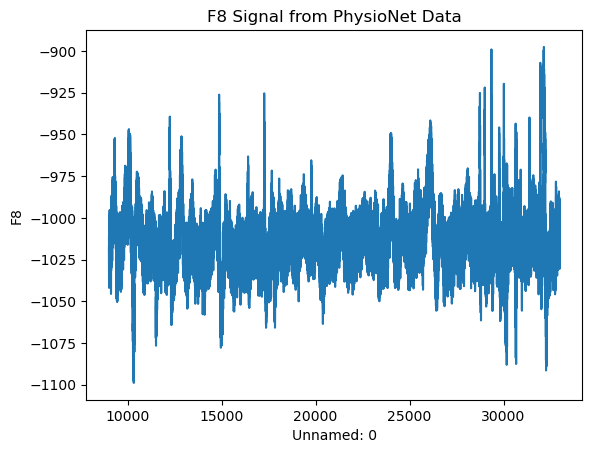

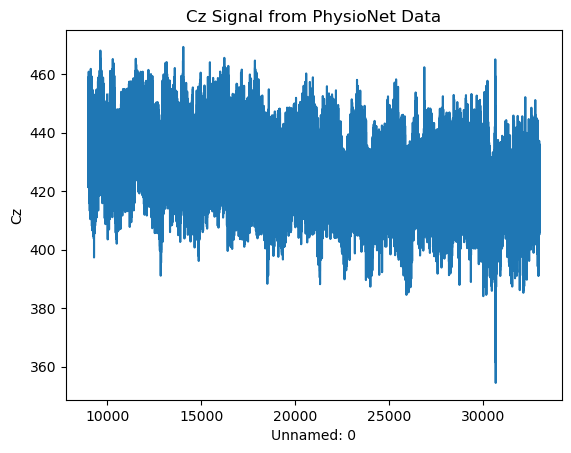

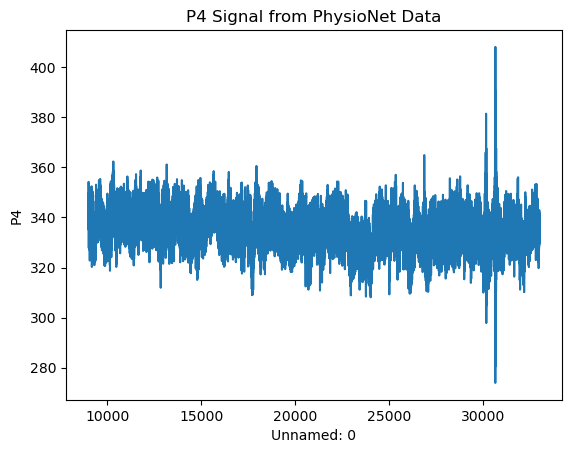

In [6]:
# Lee el archivo txt
data = pd.read_csv('C:\\Users\\Usuario\\Downloads\\s01_ex01_s01 (1).csv')

# Lee el archivo CSV
#data = pd.read_csv('C:\\Users\\Usuario\\Downloads\\s01_ex01_s01.txt')

# Verifica las primeras filas del DataFrame para inspeccionar los nombres de las columnas
print(data.head())

# Filtra solo las columnas que contienen datos de señales
columnas_señales = [col for col in data.columns if col != 'Unnamed: 0']
times=data['Unnamed: 0']
# Grafica todas las señales
for canal in columnas_señales:
    plt.figure()
    plt.plot(times, data[canal])
    plt.xlabel('Unnamed: 0')
    plt.ylabel(canal)
    plt.title(f'{canal} Signal from PhysioNet Data')
    plt.show()

In [7]:
#filtro passband

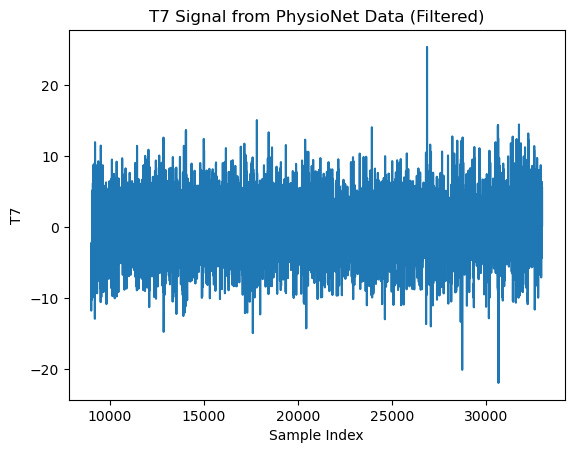

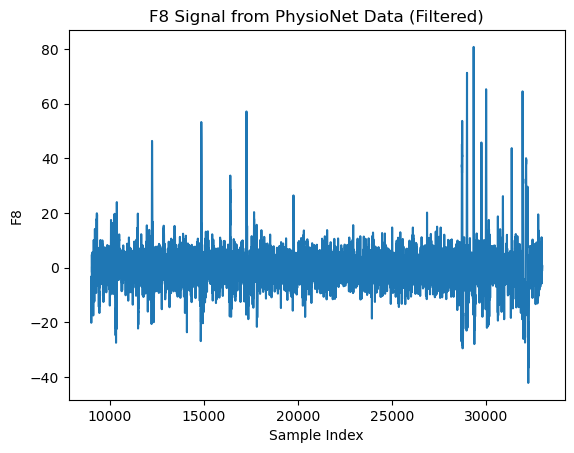

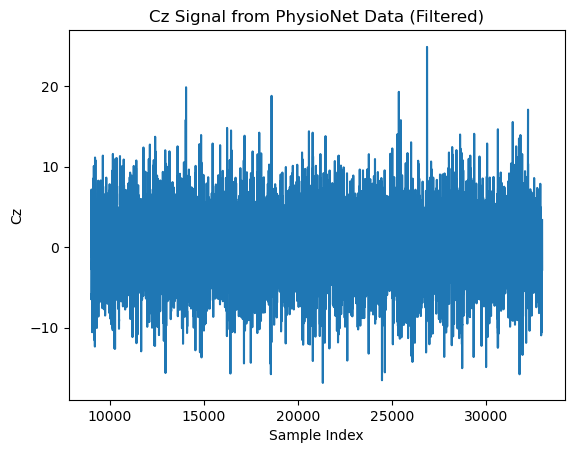

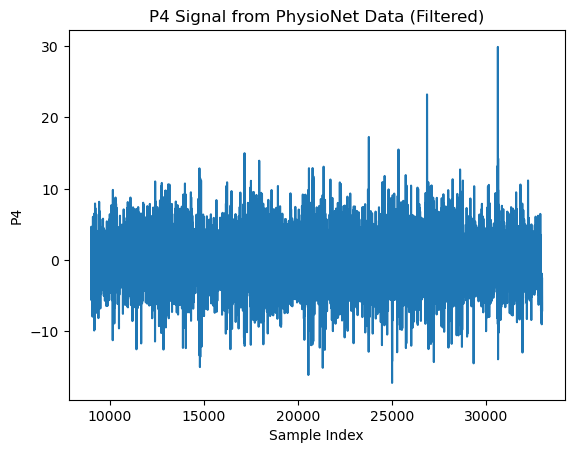

In [10]:
columnas_interes=columnas_señales

from scipy.signal import butter, filtfilt, iirnotch

# Función para crear un filtro Butterworth de banda
def butter_bandpass(lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Función para aplicar el filtro Butterworth
def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Función para crear un filtro de muesca
def notch_filter(data, freq, fs, quality):
    nyq = 0.5 * fs
    freq = freq / nyq
    b, a = iirnotch(freq, quality)
    y = filtfilt(b, a, data)
    return y
# Parámetros del filtro
fs = 200  # Frecuencia de muestreo en Hz (esto debe ser ajustado según la frecuencia de muestreo real de tus datos)
lowcut = 1.0
highcut = 40.0
notch_freq = 50.0
quality_factor = 30

# Aplica los filtros a cada señal de interés
filtered_data = pd.DataFrame()
filtered_data['Sample Index'] = times
for canal in columnas_interes:
    # Aplica el filtro Butterworth
    filtered_signal = butter_bandpass_filter(data[canal], lowcut, highcut, fs, order=1)
    # Aplica el filtro de muesca
    filtered_signal = notch_filter(filtered_signal, notch_freq, fs, quality_factor)
    # Guarda la señal filtrada
    filtered_data[canal] = filtered_signal

# Grafica solo las señales de interés filtradas
for canal in columnas_interes:
    plt.figure()
    plt.plot(times, filtered_data[canal])
    plt.xlabel('Sample Index')
    plt.ylabel(canal)
    plt.title(f'{canal} Signal from PhysioNet Data (Filtered)')
    plt.show()

In [11]:
#ICA

Creating RawArray with float64 data, n_channels=4, n_times=24000
    Range : 0 ... 23999 =      0.000 ...   119.995 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Filter length: 331 samples (1.655 s)

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 4 PCA components


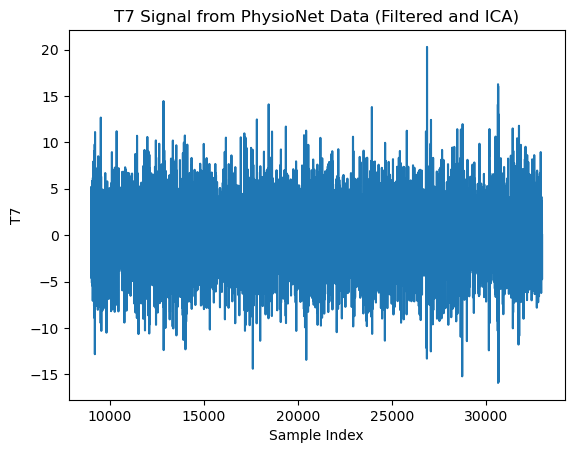

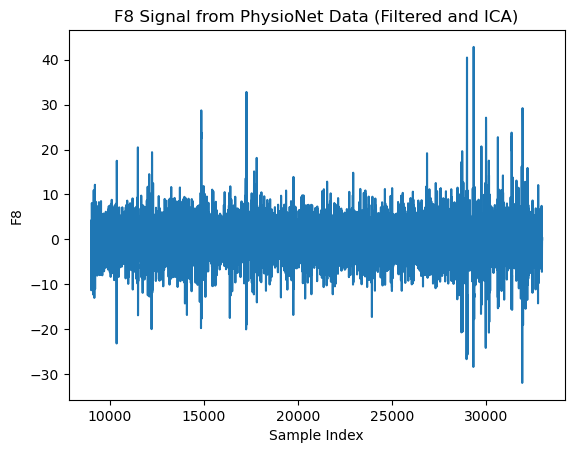

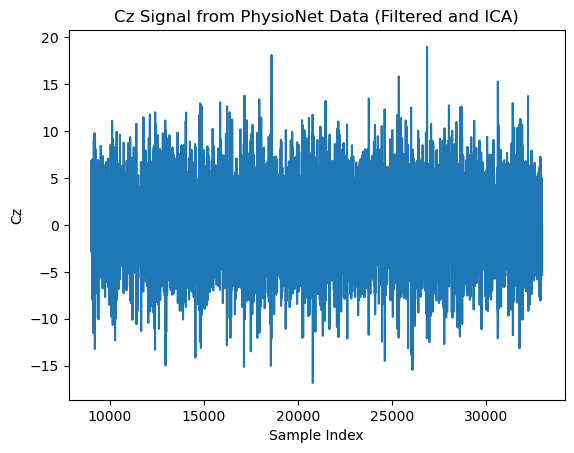

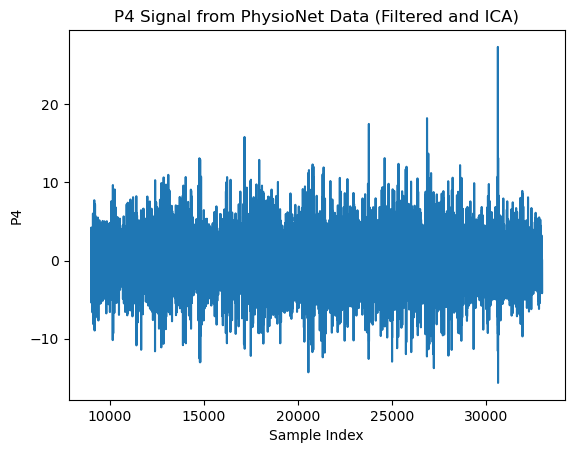

In [14]:
from mne.preprocessing import ICA
# Prepara los datos para ICA
eeg_data = filtered_data[columnas_interes].values.T

# Crear un objeto RawArray en MNE
info = mne.create_info(ch_names=columnas_interes, sfreq=fs, ch_types='eeg')
raw = mne.io.RawArray(eeg_data, info)
# Aplicar un filtro de alta frecuencia (high-pass) antes de ajustar el ICA
raw.filter(l_freq=4.0, h_freq=None)
# Aplicar ICA
ica = ICA(n_components=len(columnas_interes), method='fastica', random_state=0)
ica.fit(raw)

# Aplicar el filtro ICA para remover componentes
ica_filtered_raw = ica.apply(raw)

# Convertir de vuelta a DataFrame para la graficación
ica_filtered_data = pd.DataFrame(ica_filtered_raw.get_data().T, columns=columnas_interes)
ica_filtered_data['Sample Index'] = times

# Grafica solo las señales de interés filtradas y después de ICA
for canal in columnas_interes:
    plt.figure()
    plt.plot(times, ica_filtered_data[canal])
    plt.xlabel('Sample Index')
    plt.ylabel(canal)
    plt.title(f'{canal} Signal from PhysioNet Data (Filtered and ICA)')
    plt.show()

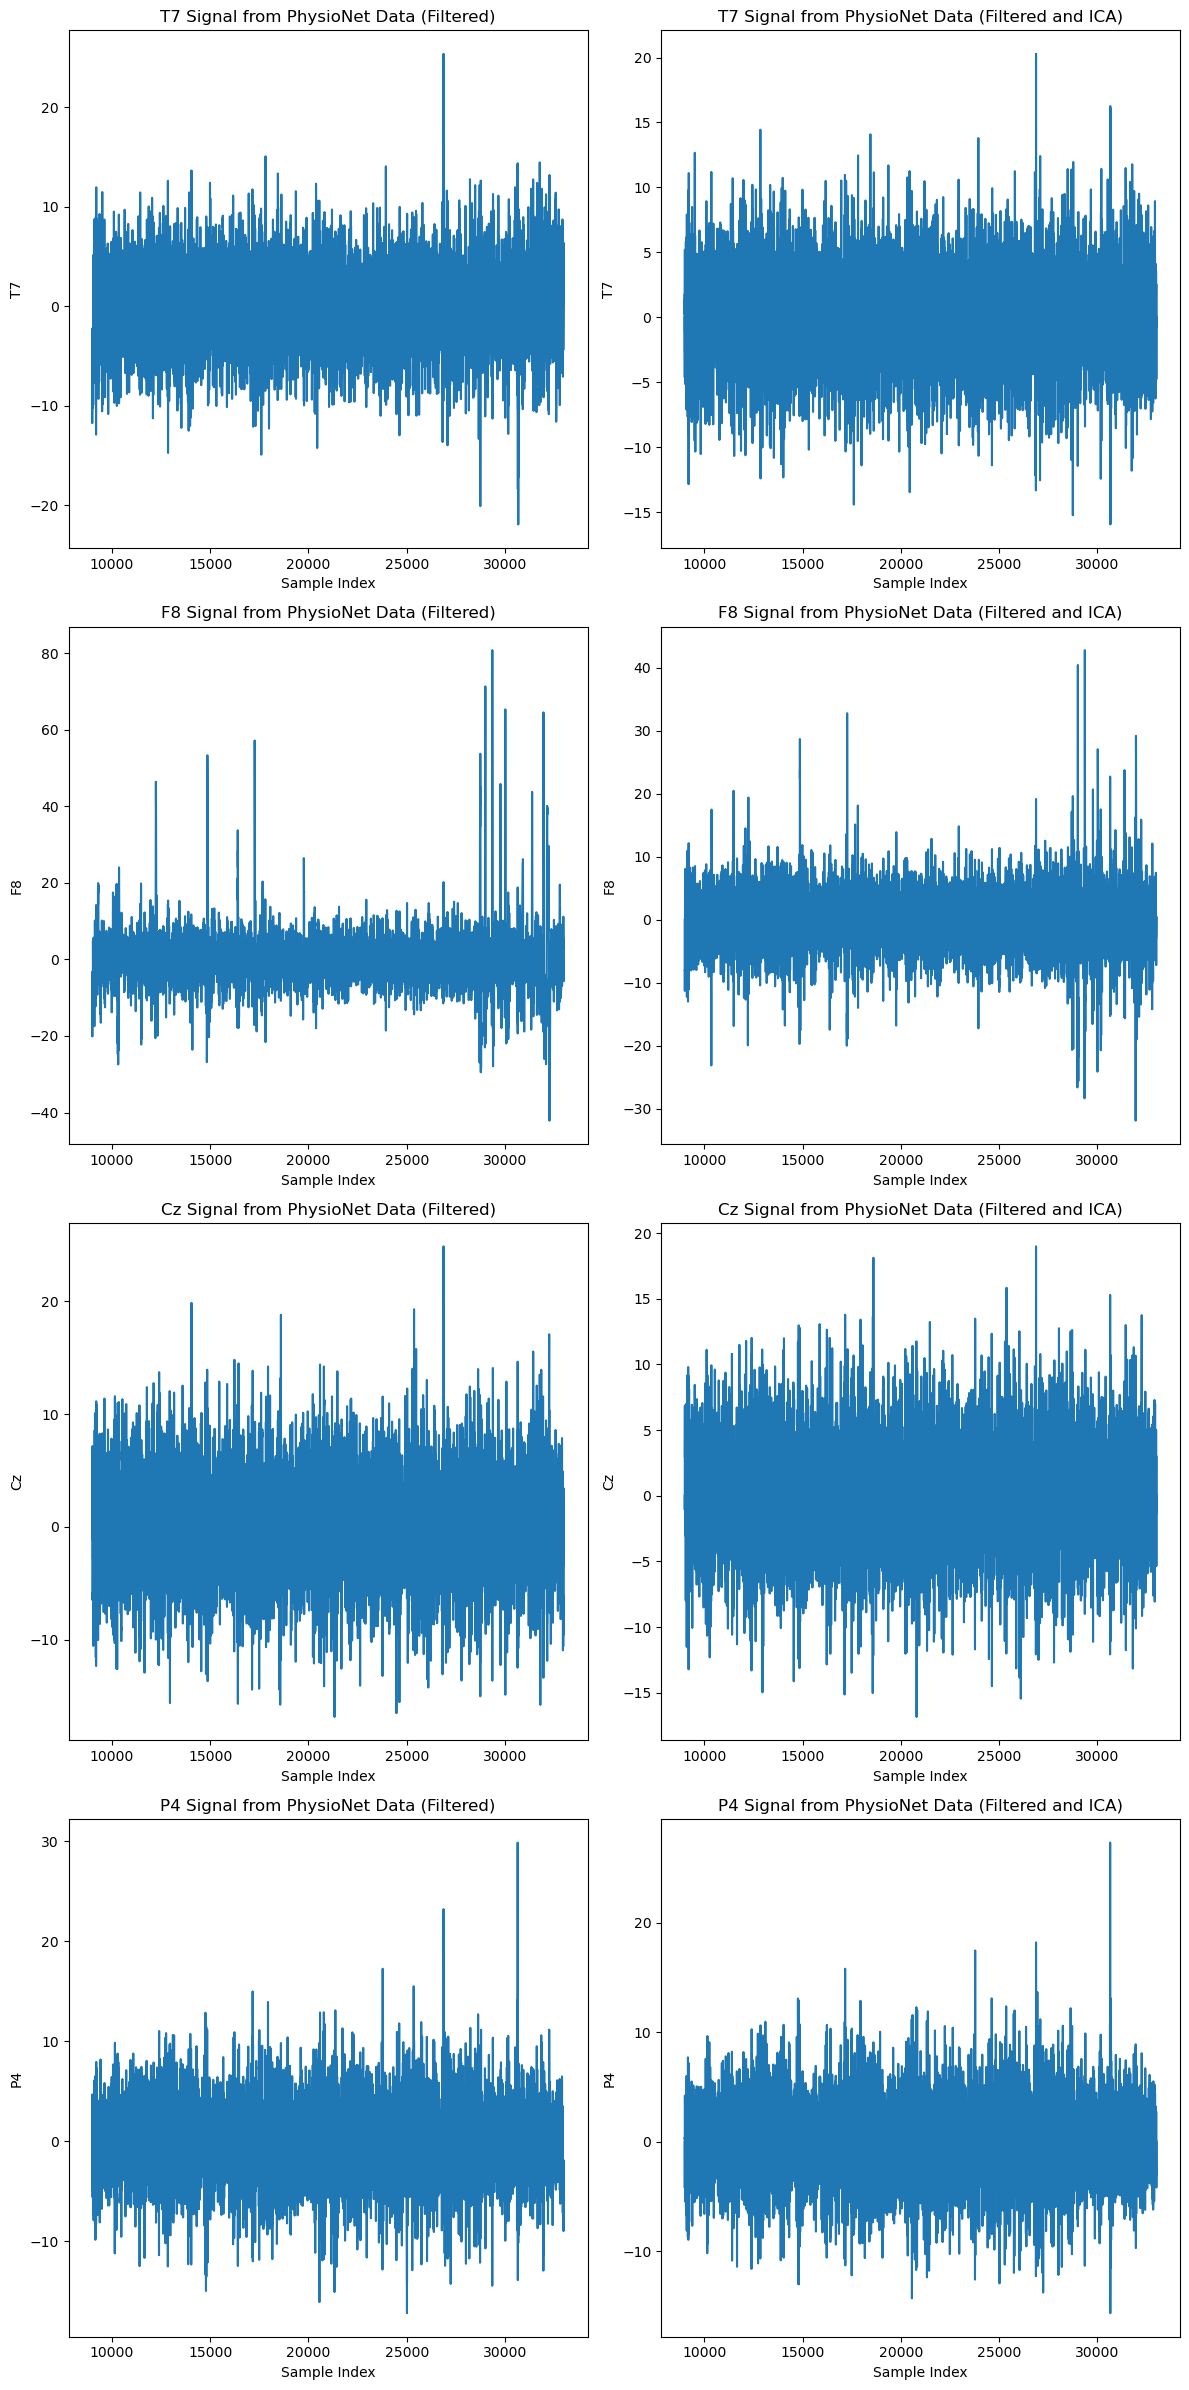

In [15]:
# Gráficos COMPARAR LOS GRAFICOS
fig, axs = plt.subplots(len(columnas_interes), 2, figsize=(12, 6*len(columnas_interes)))

for i, canal in enumerate(columnas_interes):
    # Gráfico del código 1
    axs[i, 0].plot(times, filtered_data[canal])
    axs[i, 0].set_xlabel('Sample Index')
    axs[i, 0].set_ylabel(canal)
    axs[i, 0].set_title(f'{canal} Signal from PhysioNet Data (Filtered)')

    # Gráfico del código 2
    axs[i, 1].plot(times, ica_filtered_data[canal])
    axs[i, 1].set_xlabel('Sample Index')
    axs[i, 1].set_ylabel(canal)
    axs[i, 1].set_title(f'{canal} Signal from PhysioNet Data (Filtered and ICA)')

plt.tight_layout()
plt.show()

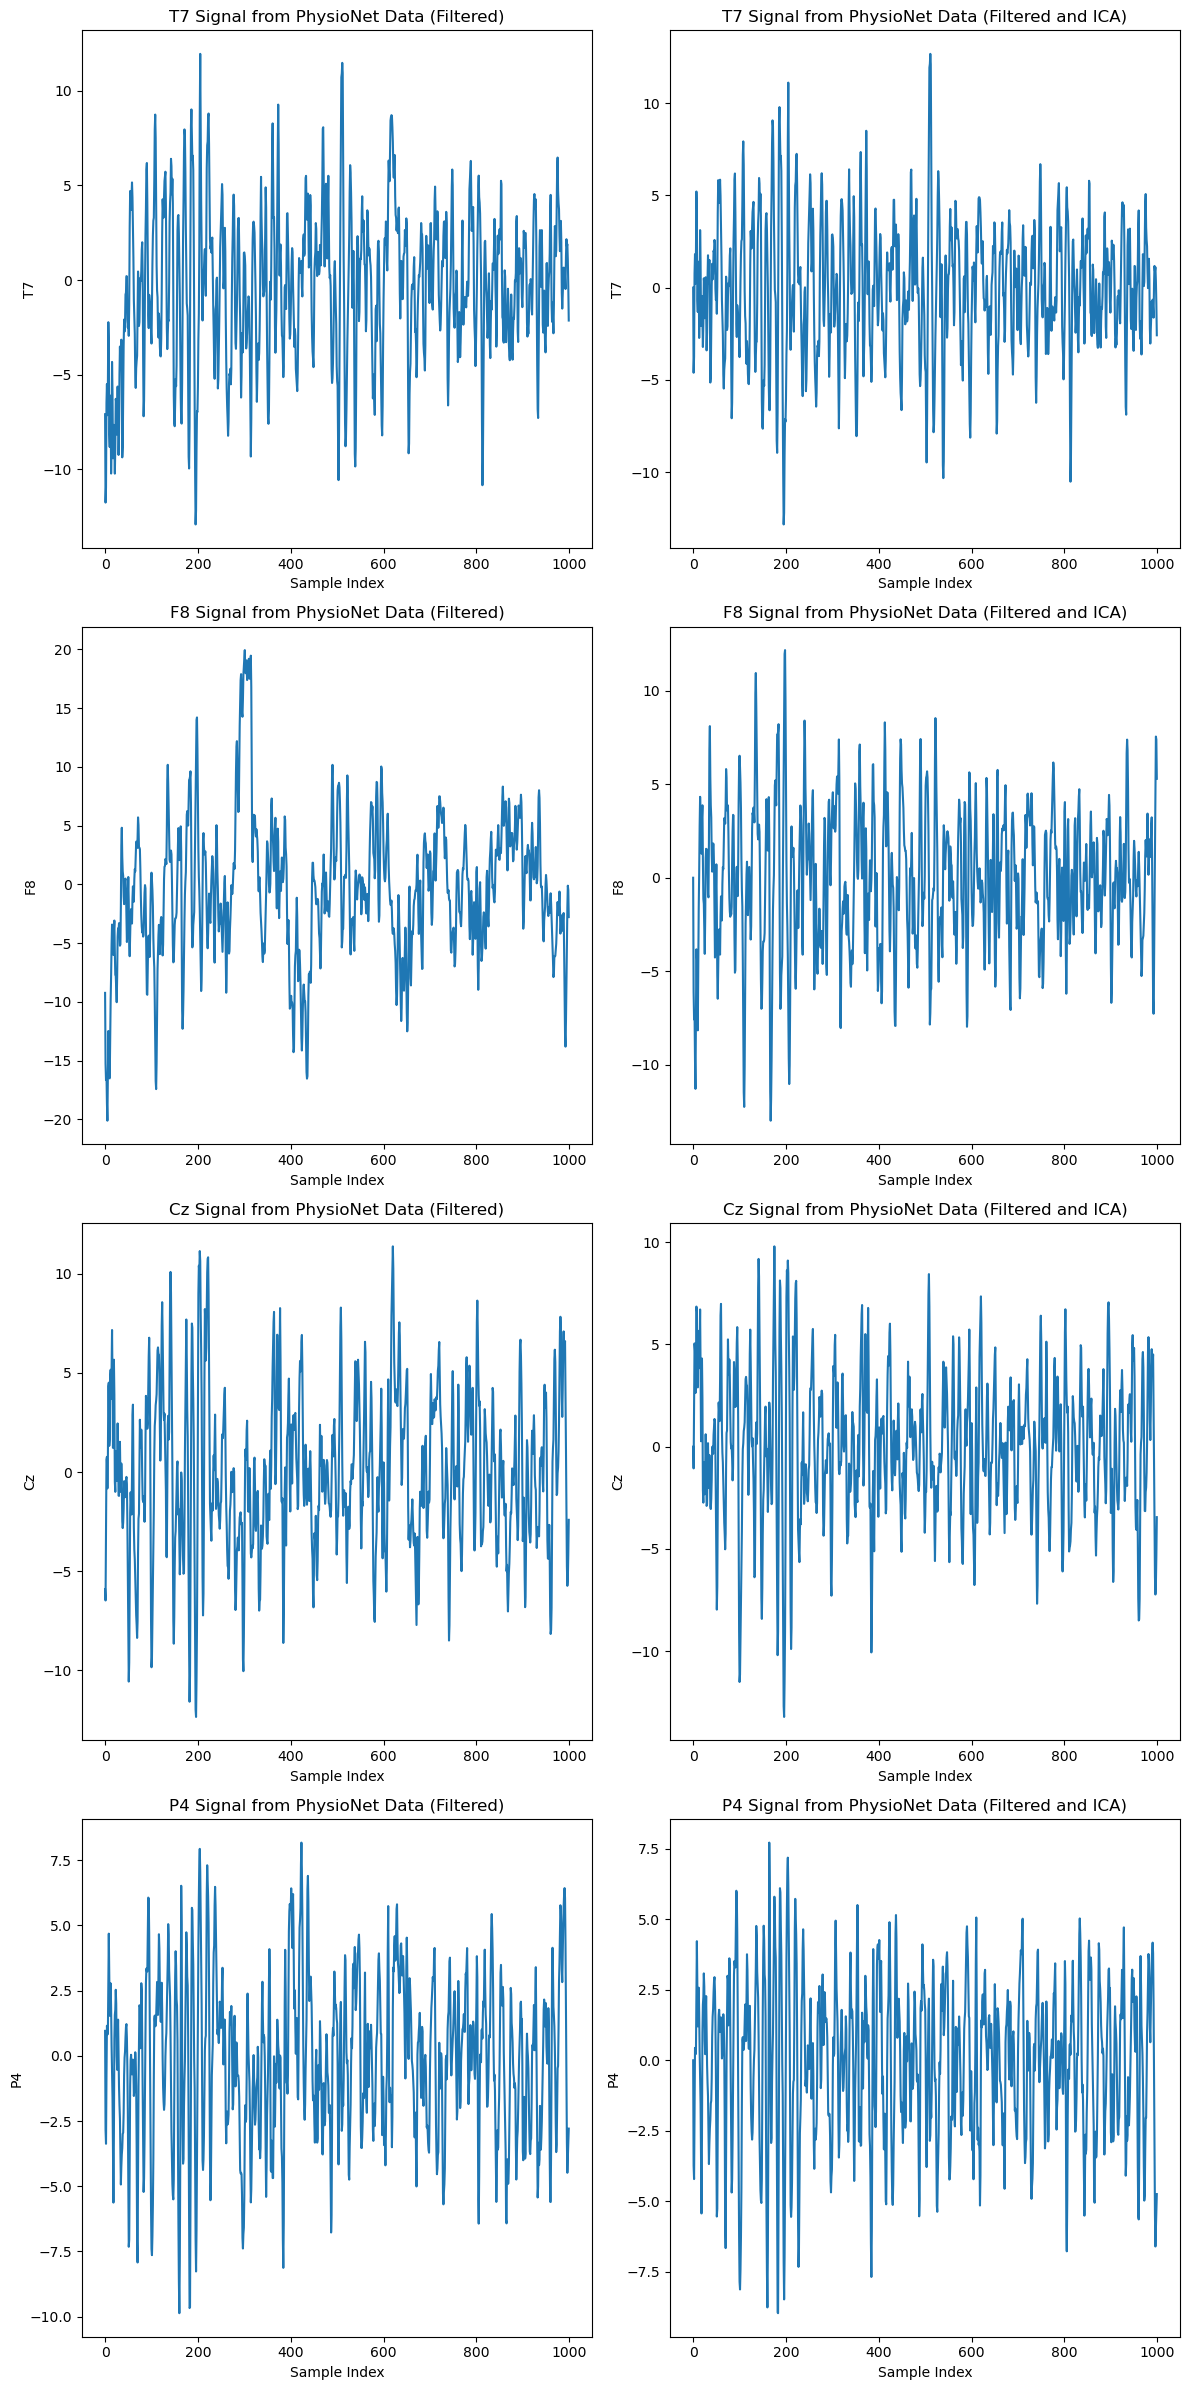

In [17]:
#COMPARAR LAS SEÑALES FILTRADA VS FILTRADA +ICA
# Definición del rango de muestras a mostrar 
sample_range = range(1000)

# Gráficos
fig, axs = plt.subplots(len(columnas_interes), 2, figsize=(12, 6*len(columnas_interes)))

for i, canal in enumerate(columnas_interes):
    # Gráfico del código 1
    axs[i, 0].plot(sample_range, filtered_data[canal][:len(sample_range)])
    axs[i, 0].set_xlabel('Sample Index')
    axs[i, 0].set_ylabel(canal)
    axs[i, 0].set_title(f'{canal} Signal from PhysioNet Data (Filtered)')
    
    # Gráfico del código 2
    axs[i, 1].plot(sample_range, ica_filtered_data[canal][:len(sample_range)])
    axs[i, 1].set_xlabel('Sample Index')
    axs[i, 1].set_ylabel(canal)
    axs[i, 1].set_title(f'{canal} Signal from PhysioNet Data (Filtered and ICA)')

plt.tight_layout()
plt.show()

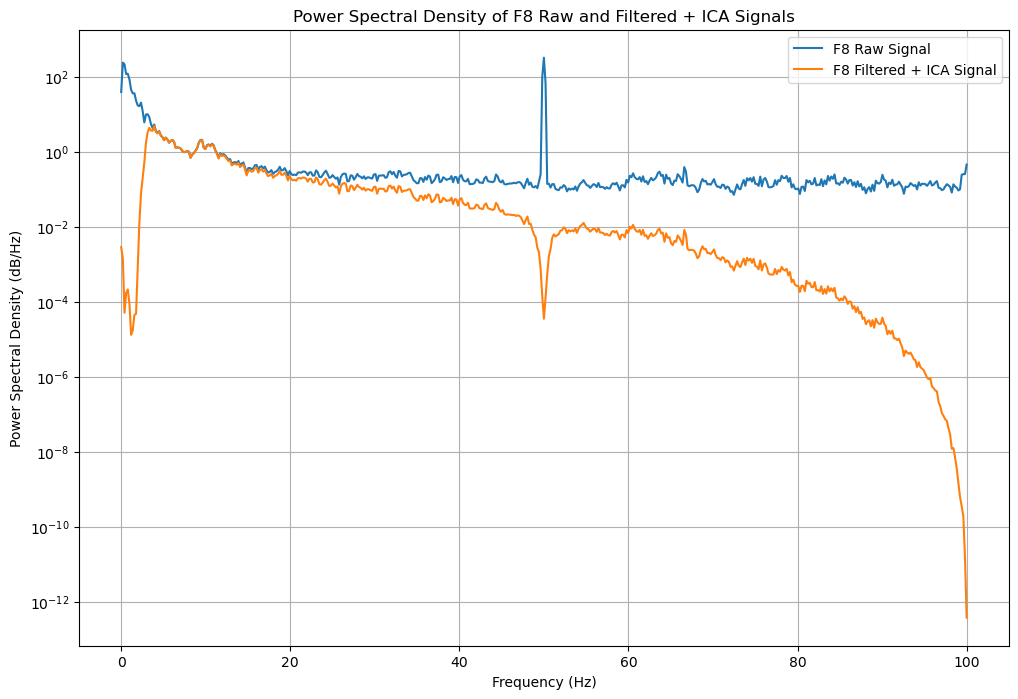

In [23]:
from scipy.signal import welch
# Selecciona el canal específico para el cual deseas mostrar la PSD
canal_seleccionado = 'F8'

# Calcula la PSD solo para el canal seleccionado
freqs_raw, psd_raw = welch(data[canal_seleccionado], fs=fs, nperseg=1024)
freqs_filtered_ica, psd_filtered_ica = welch(ica_filtered_data[canal_seleccionado], fs=fs, nperseg=1024)

# Grafica la PSD solo para el canal seleccionado
plt.figure(figsize=(12, 8))
plt.semilogy(freqs_raw, psd_raw, label=f'{canal_seleccionado} Raw Signal')
plt.semilogy(freqs_filtered_ica, psd_filtered_ica, label=f'{canal_seleccionado} Filtered + ICA Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB/Hz)')
plt.title(f'Power Spectral Density of {canal_seleccionado} Raw and Filtered + ICA Signals')
plt.legend()
plt.grid(True)
plt.show()




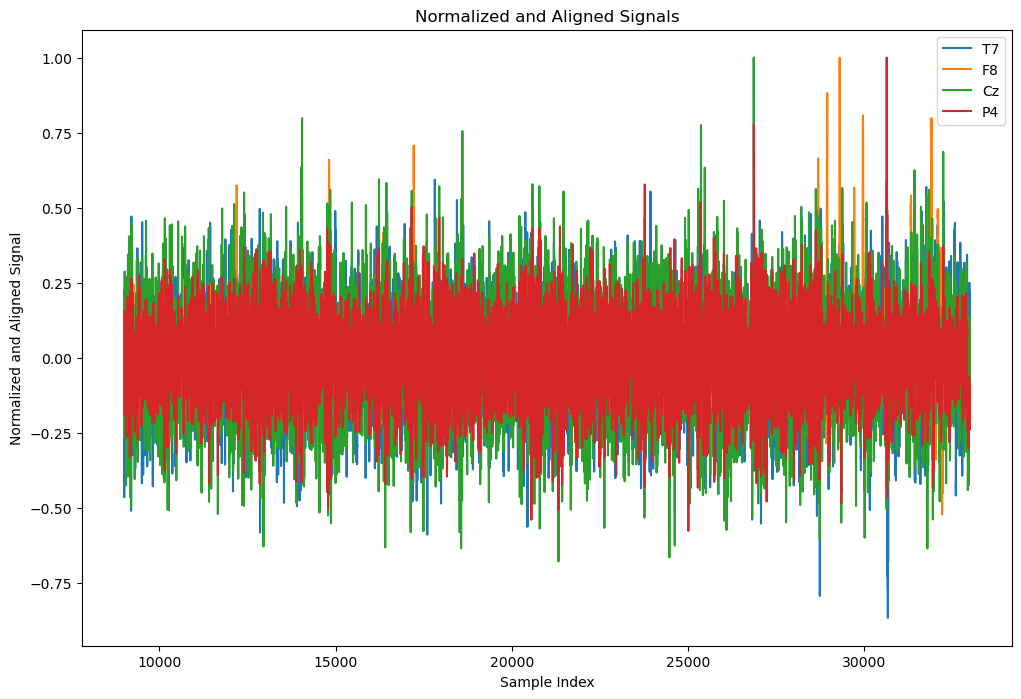

In [25]:
import numpy as np

# Normalización
normalized_data = filtered_data.copy()
for canal in columnas_interes:
    max_abs = np.max(np.abs(normalized_data[canal]))
    normalized_data[canal] /= max_abs

# Alineación
aligned_data = normalized_data.copy()
reference_channel = 'T7'
for canal in columnas_interes:
    if canal != reference_channel:
        # Calcula el desplazamiento temporal entre el canal actual y el canal de referencia
        cross_corr = np.correlate(aligned_data[reference_channel], aligned_data[canal], mode='full')
        lag = np.argmax(cross_corr) - len(aligned_data[reference_channel]) + 1
        # Aplica el desplazamiento temporal para alinear los canales
        if lag > 0:
            aligned_data[canal] = np.concatenate((aligned_data[canal][lag:], np.zeros(lag)))
        elif lag < 0:
            lag = -lag
            aligned_data[canal] = np.concatenate((np.zeros(lag), aligned_data[canal][:-lag]))

# Graficar las señales normalizadas y alineadas
plt.figure(figsize=(12, 8))
for canal in columnas_interes:
    plt.plot(times, aligned_data[canal], label=canal)
plt.xlabel('Sample Index')
plt.ylabel('Normalized and Aligned Signal')
plt.title('Normalized and Aligned Signals')
plt.legend()
plt.show()


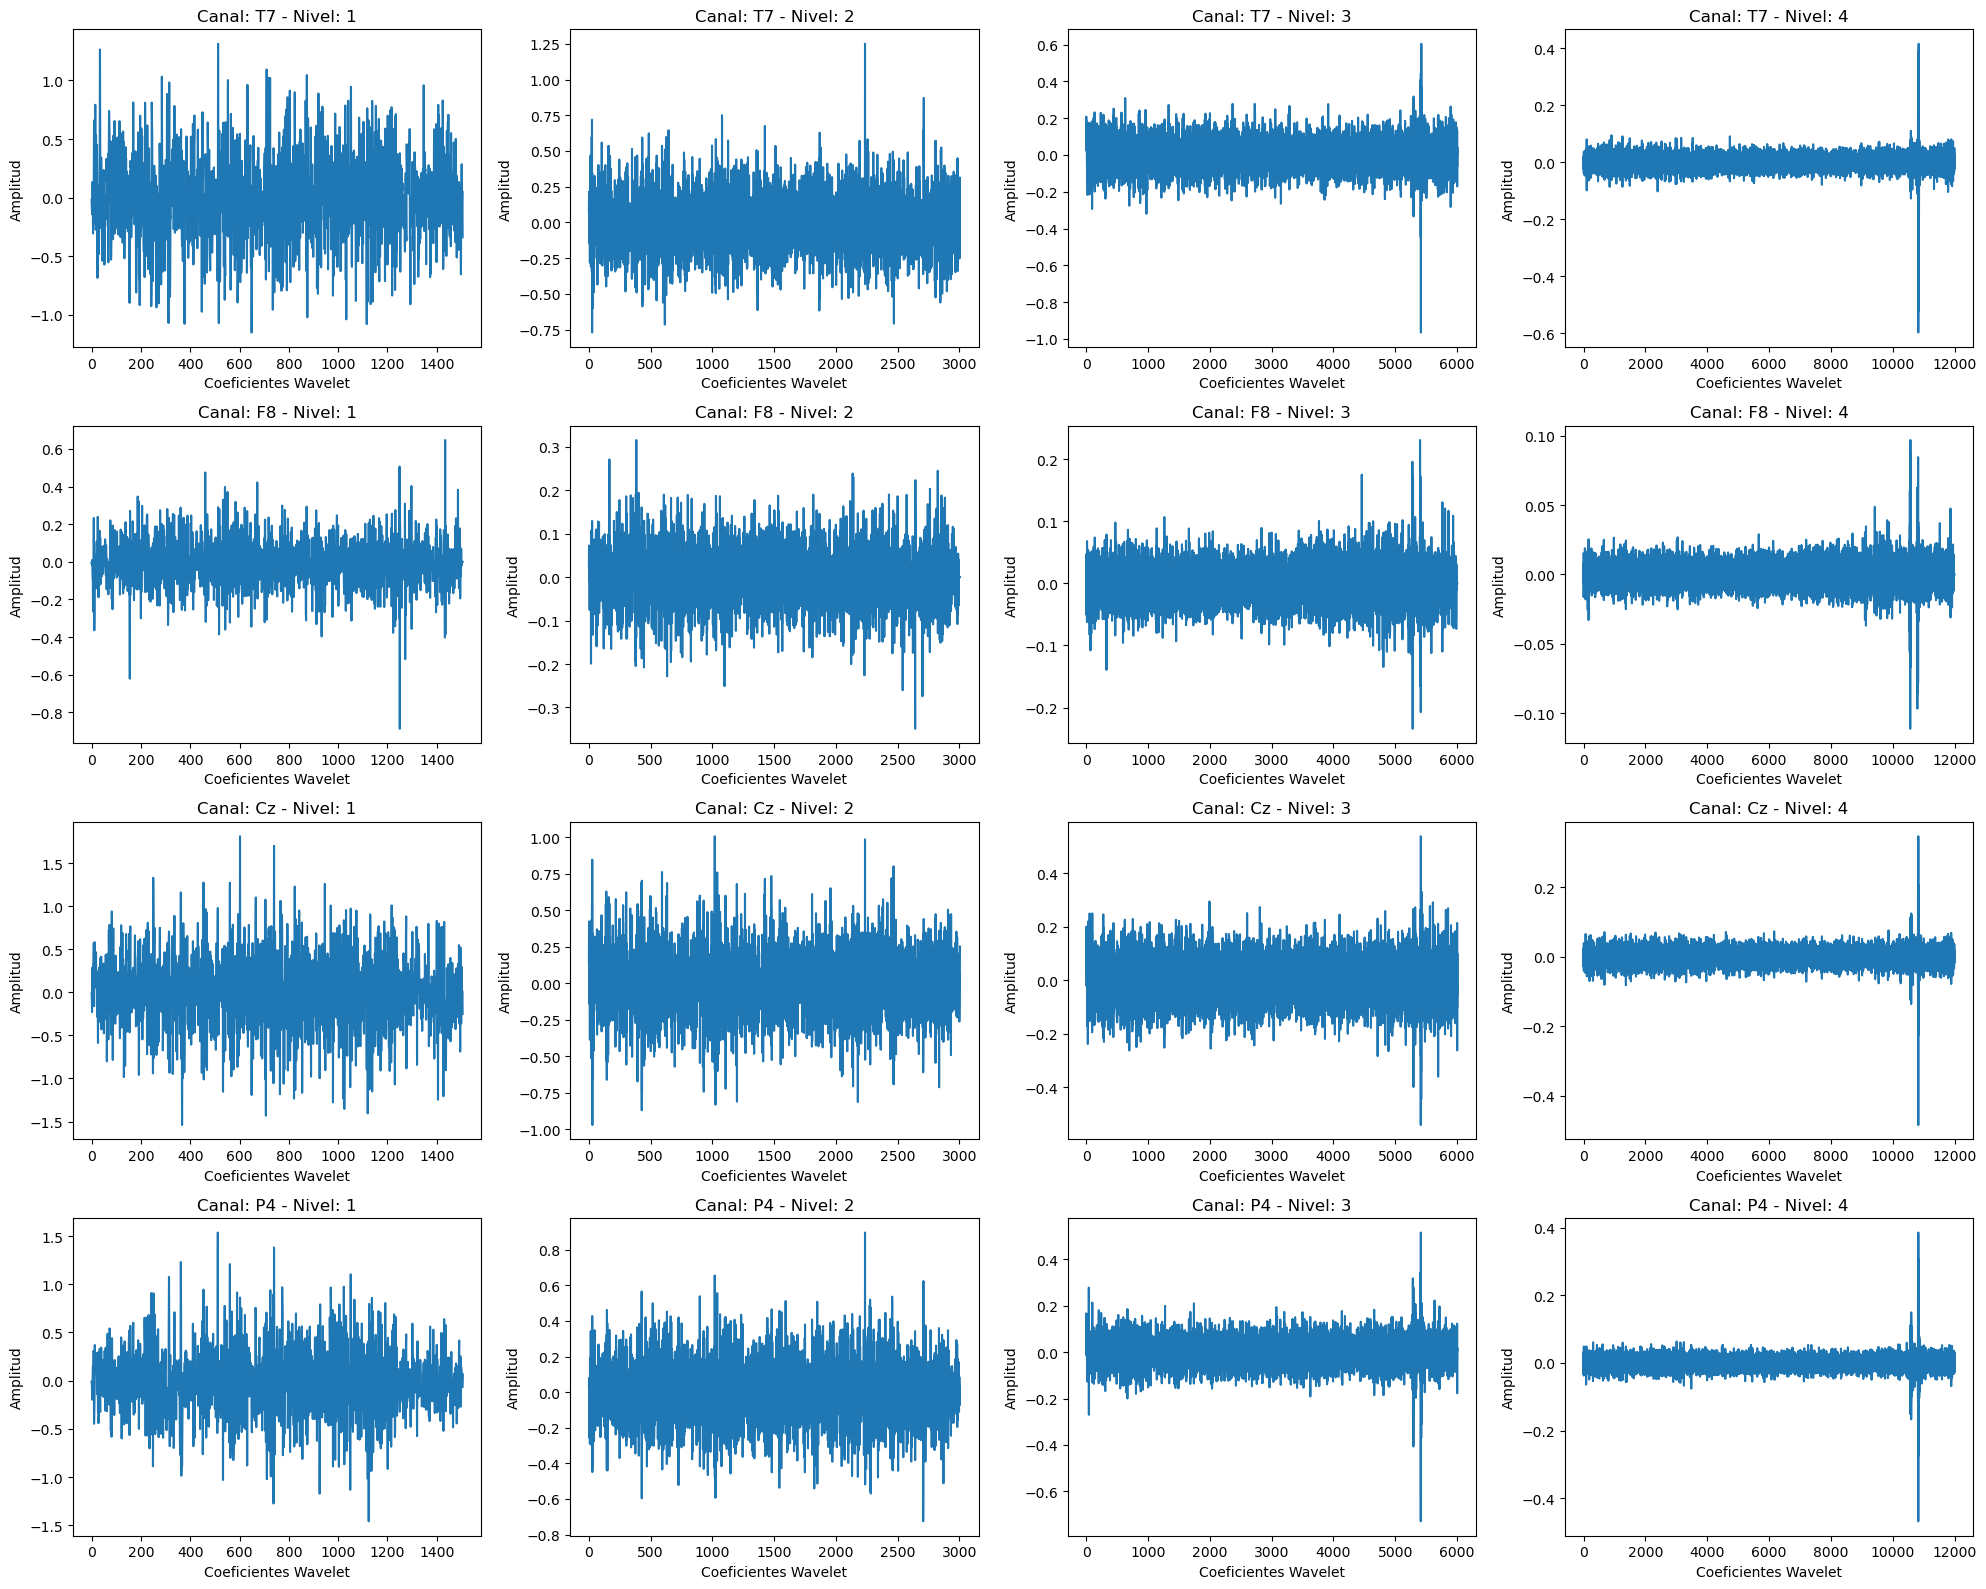

In [32]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Parámetros de la transformada wavelet
wavelet = 'db4'  # Daubechies wavelet de orden 4
n_layers = 4

# Aplicar la transformada wavelet a cada canal
coeffs = {}
for canal in columnas_interes:
    coeffs[canal] = pywt.wavedec(aligned_data[canal], wavelet, level=n_layers)

# Crear una función para extraer coeficientes wavelet en bandas de subfrecuencia
def extract_wavelet_coeffs(coeffs):
    wavelet_features = []
    for i in range(1, len(coeffs)):  # Ignoramos el coeficiente de aproximación (A)
        wavelet_features.append(coeffs[i])
    return wavelet_features

# Extraer características wavelet para cada canal
wavelet_features = {canal: extract_wavelet_coeffs(coeffs[canal]) for canal in columnas_interes}

# Graficar las características wavelet
fig, axs = plt.subplots(len(columnas_interes), n_layers, figsize=(20, 4 * len(columnas_interes)))

for i, canal in enumerate(columnas_interes):
    for j in range(n_layers):
        axs[i, j].plot(wavelet_features[canal][j])
        axs[i, j].set_title(f'Canal: {canal} - Nivel: {j+1}')
        axs[i, j].set_xlabel('Coeficientes Wavelet')
        axs[i, j].set_ylabel('Amplitud')

plt.tight_layout()
plt.show()
